# In this notebook I made an gaussian process regression with customized kernel, likelihood and mean function.

In [80]:
import pickle as pkl
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary, positive, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow.config.__config__ import default_float, default_int
from gpflow.base import Parameter


set_default_float(np.float64)
set_default_summary_fmt("notebook")

plt.style.use("ggplot")
%matplotlib inline
# np.random.seed(1366)
tf.config.run_functions_eagerly(True)

Input data:

In [81]:
switch_mean = False
    
n_train =20

Define the customized kernel

In [82]:
data_pd = 'metric_euc.txt'
def _octonion_dist(X, X2):
    X = tf.reshape(X, [-1,1])
    pd = np.loadtxt(data_pd)
    X2 = tf.reshape(X2, [-1,1])
    dist0 = np.zeros((len(X), len(X2)))
    dist = tf.Variable(dist0) # Use variable 
    for i in range(len(X)):
        init_val = int(X[i].numpy())
        for j in range(len(X2)):
            fin_val = int(X2[j].numpy())
            dist0[i,j] = pd[init_val, fin_val]
    dist.assign(dist0)
    return dist

def _octonion_dist_single(X):
    X = tf.reshape(X, [-1,1])
    pd = np.loadtxt(data_pd)
    dist0 = np.zeros((len(X)))
    dist = tf.Variable(dist0) # Use variable 
    for i in range(len(X)):
        init_val = int(X[i].numpy())

        dist0[i] = pd[init_val, init_val]
    dist.assign(dist0)
    return dist

class GBKernel(gpflow.kernels.Kernel):   
    def __init__(self, variance=1, lengthscales=.5, **kwargs):
        super().__init__(**kwargs)
        self.variance = gpflow.Parameter(variance, transform=positive())
        self.lengthscales = gpflow.Parameter(lengthscales, transform=positive())
        self._validate_ard_active_dims(self.lengthscales)
    
    def K(self, X, X2=None):
        X = X[:,0]
        if X2 is None:
            X2 = X
        else:
            X2 = X2[:,0]
#         a = self.variance * tf.exp(-_octonion_dist(X, X2)/self.lengthscales)
        a = self.variance * tf.exp(-0.5 * _octonion_dist(X, X2)/self.lengthscales)
        tf.debugging.check_numerics(self.lengthscales, 'hi')
        return a

    def K_diag(self, X):
        X = X[:,0]
#         a = self.variance * tf.exp(-_octonion_dist_single(X)/self.lengthscales)
        a = self.variance * tf.exp(-0.5 * _octonion_dist_single(X)/self.lengthscales)
        tf.debugging.check_numerics(self.lengthscales, 'hi')
        return a

Define the multi varince noise in the data points 

In [83]:
class HeteroskedasticGaussian(gpflow.likelihoods.Likelihood):
    def __init__(self, **kwargs):
        # this likelihood expects a single latent function F, and two columns in the data matrix Y:
        super().__init__(latent_dim=1, observation_dim=2, **kwargs)

    def _log_prob(self, F, Y):
        # log_prob is used by the quadrature fallback of variational_expectations and predict_log_density.
        # Because variational_expectations is implemented analytically below, this is not actually needed,
        # but is included for pedagogical purposes.
        # Note that currently relying on the quadrature would fail due to https://github.com/GPflow/GPflow/issues/966
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        return gpflow.logdensities.gaussian(Y, F, NoiseVar)

    def _variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        Fmu, Fvar = Fmu[:, 0], Fvar[:, 0]
        return (
            -0.5 * np.log(2 * np.pi)
            - 0.5 * tf.math.log(NoiseVar)
            - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar
        )

    # The following two methods are abstract in the base class.
    # They need to be implemented even if not used.

    def _predict_log_density(self, Fmu, Fvar, Y):
        raise NotImplementedError

    def _predict_mean_and_var(self, Fmu, Fvar):
        raise NotImplementedError

Define the customized mean function

In [84]:
from gpflow.config.__config__ import default_float, default_int
from gpflow.base import Parameter

class GB_mean(gpflow.mean_functions.MeanFunction):
    """
    y_i = A x_i + b
    y_i = A x_i^2 + B X_i + c
    """
    def __init__(self):
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant.

        If X has N rows and D columns, and Y is intended to have Q columns,
        then A must be [D, Q], b must be a vector of length Q.
        """
        gpflow.mean_functions.MeanFunction.__init__(self)
#         A = np.ones((1, 1), dtype=default_float()) if A is None else A
#         b = np.zeros(1, dtype=default_float()) if b is None else b
#         self.A = Parameter(np.atleast_2d(A))
#         self.b = Parameter(b)
        
    def __call__(self, X):
        X = X[:,0]
        X = tf.reshape(X,[-1,1])
#         out = tf.tensordot(X, self.A, [[-1], [0]]) + self.b
#         print(out.shape)
        
        data0 = "read_mean.txt"
        data = np.loadtxt(data0)
        ang = data[:,0]
        Y = data[:,1]
        x_new = X.numpy().astype(int)
        Y_out = Y[x_new].reshape(-1,1)
        Y_output = tf.convert_to_tensor(Y_out, dtype=np.float64)
        Y_output = tf.reshape(Y_output, [-1,1])
        return Y_output


Read the data for [110] symm tilt gbs data

In [85]:
# read the original data 
pkl_name = '../../data/symm_angs_engs.pkl'
jar = open(pkl_name, 'rb')
s2 = pkl.load(jar,encoding='latin1')
jar.close()

Angle = s2['angs']                 # in radian
Y0 = s2['engs']                     # eng is mJ/m^2
cusp_ang = s2['cusps']['angs']      # the angle of cusps in radian 
cusp_Es = s2['cusps']['engs']       # the energy of cusps in radian


# read the mean_eng data
read_mean = np.loadtxt('read_mean.txt')


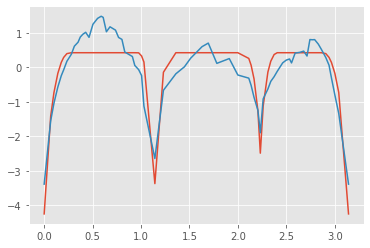

In [86]:
plt.plot(Angle, read_mean[:,1])
plt.plot(Angle, Y_all)

In [87]:
N = len(Angle) # number of the data points
x = np.linspace(0,N - 1, N, dtype=int)
label = np.zeros((N))
X = np.hstack([x.reshape(-1,1), label.reshape(-1,1)])
# normalize the data
mean_y = np.mean(Y0)
std_y = np.std(Y0)
Y = (Y0 - np.mean(Y0)) / np.std(Y0)
Y_all = Y.reshape(-1, 1)
Angle = Angle.reshape(-1, 1)

# normalize the data
mean_data = (read_mean - mean_y) / std_y

# I chose n_train gbs as training data set randomly
id_train0 = np.sort(np.random.choice(N, size=n_train, replace=False))
# id_train0 = np.floor(np.linspace(0,67,n_train))
id_train1 = np.array([0, 29, 43, 67])
id_train0 = np.concatenate((id_train0, id_train1),axis=0)
id_train0 = np.unique(id_train0).astype(int)

id_train = np.hstack([id_train0.reshape(-1,1), X[id_train0][:,1].reshape(-1, 1)])
Y_train = Y_all[id_train[:,0].astype(int)].reshape(-1,1)
Nois_train = NoiseVar[id_train[:,0].astype(int)].reshape(-1,1)

# # # I chose rest of the gbs as the test set
id_test0 = X[~np.in1d(X[:,0], id_train0)][:,0]
id_test = np.hstack([id_test0.reshape(-1,1), X[id_test0.astype(int)][:,1].reshape(-1, 1)])
Y_test = Y_all[id_test0.astype(int)].reshape(-1,1)
Nois_test = NoiseVar[id_test[:,0].astype(int)].reshape(-1,1)


In [88]:
Y_data = np.hstack([Y_train, Nois_train])
Y_data_test = np.hstack([Y_test, Nois_test])

Constructing the model

In [89]:
# model construction
likelihood = HeteroskedasticGaussian()
kernel = GBKernel()
model = gpflow.models.VGP((id_train, Y_data), kernel=kernel, mean_function=GB_mean(), likelihood=likelihood, num_latent_gps=1)

Optimizing the model

In [98]:
natgrad = NaturalGradient(gamma=1)
adam = tf.optimizers.Adam()

set_trainable(model.q_mu, False)
set_trainable(model.q_sqrt, False)

for _ in range(ci_niter(1000)):
    natgrad.minimize(model.training_loss, [(model.q_mu, model.q_sqrt)])
    adam.minimize(model.training_loss, model.trainable_variables)

Prediction

In [96]:
mean, var = model.predict_f(id_test)
mean_t, var_t = model.predict_f(id_train)

Plot the predicted-actual graph

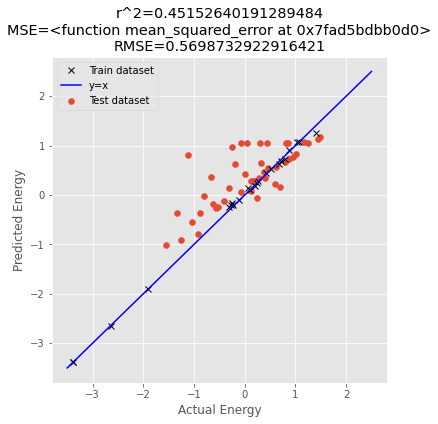

In [97]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_all[id_test[:,0].astype(int)], mean.numpy())

import math
rmse = math.sqrt(mean_squared_error(Y_all[id_test[:,0].astype(int)], mean.numpy()))


x = np.linspace(-3.5, 2.5,100)
plt.figure(figsize=(6, 6))

plt.scatter(Y_all[id_test[:,0].astype(int)], mean,label="Test dataset")
plt.plot(Y_all[id_train[:,0].astype(int)], mean_t, 'kx', label="Train dataset")
plt.plot(x, x,'b', label='y=x')
plt.legend()
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
from sklearn.metrics import r2_score
r2 = r2_score(Y_all[id_test[:,0].astype(int)], mean)
plt.title('r^2='+str(r2) + '\n' + 'MSE=' + str(mean_squared_error) + '\n' + 'RMSE=' + str(rmse))
plt.savefig('AP_withopt.jpg')

<ErrorbarContainer object of 3 artists>

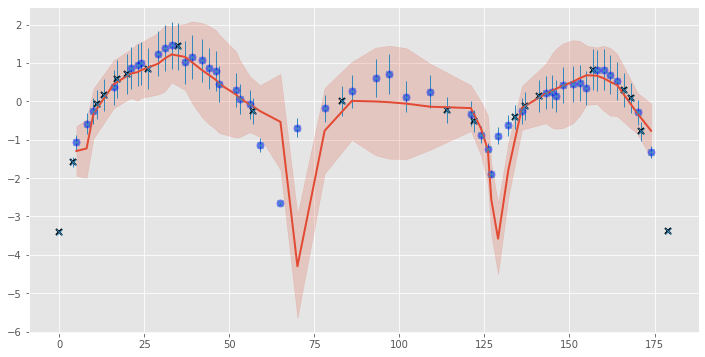

In [34]:

mu, var = model.predict_f(id_test)

plt.figure(figsize=(12, 6))
plt.plot(ang[id_train[:,0].astype(int)].reshape(-1), Y_all[id_train[:,0].astype(int)], "kx", mew=2, label="GT train_data")
plt.plot(ang[id_test[:,0].astype(int)].reshape(-1), Y_all[id_test[:,0].astype(int)], "bo", mew=2, alpha=.4, label="GT test_data")
plt.plot(ang[id_test[:,0].astype(int)].reshape(-1), mean.numpy(), lw=2, label="Predicted mean")

plt.fill_between(
    ang[id_test[:,0].astype(int)],
    mu[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mu[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.errorbar(
    ang,
    Y,
    yerr=2 * (np.sqrt(NoiseVar)).squeeze(),
    marker="x",
    lw=0,
    elinewidth=1.0,
    color="C1",
)
# _ = plt.xlim(-5, 5)